<h1 style='color: green; font-size: 36px; font-weight: bold;'>Exploratory Data Analysis: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [3]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [4]:
dataset = pd.read_csv('houses_to_rent_analisado.csv', sep=',')

In [5]:
dataset.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,São Paulo,70,2,1,1,7,0,0,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,0,1,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,0,1,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,0,1,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,1,1,0,800,25,11,836


## Correlações entre as variáveis 

<AxesSubplot:>

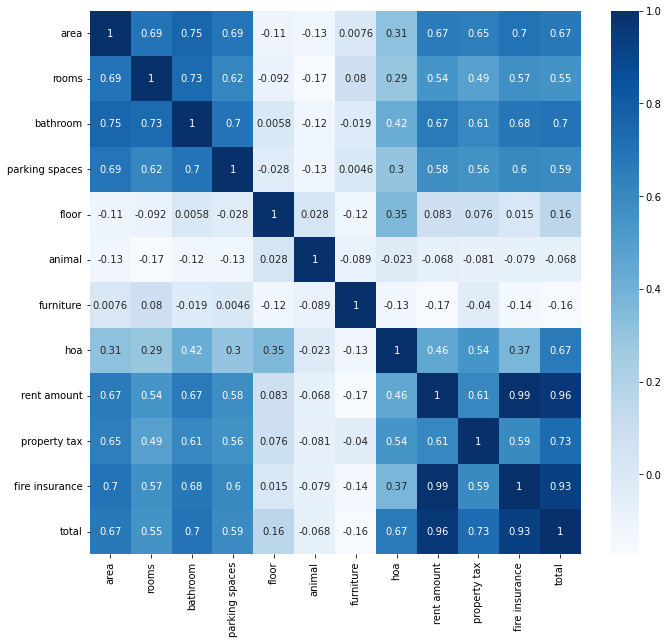

In [6]:
corr = dataset.drop(['city'], axis=1).corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

Desconsiderando as features 'floor', 'animal' e 'furniture', todas as outras features possui uma correlação positiva entre si. O que é  justificado pelo fato de quanto maior as features que estão relacionadas com a área, maior será o custo do imóvel.

## Overview

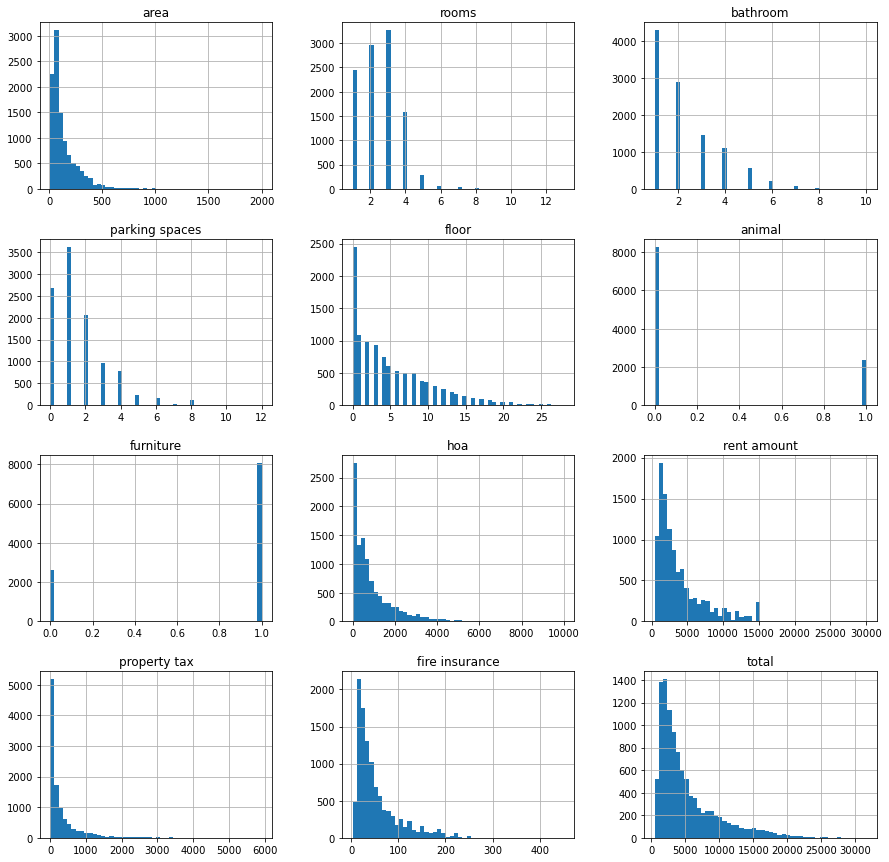

In [7]:
histograma = dataset.hist(bins=50, figsize=(15, 15))

## Exploratory Data Analysis

### Hipóteses

- Imoveis que aceitam animais possuiem um aluguel total maior;
- Imoveis que não são mobiliados têm um valor de aluguel menor;
- Existe uma tendêcia de aumento nos valores dos alugueis com o aumento dos andares;
- Há influência da cidade sobre os preços de alugueis;
- Na cidade de São Paulo existe variação da composição do custo total de aluguel quando a aumento da área.

### Influência do animal (aceitar ou não) nos valores médios do aluguel do imóvel

In [8]:
quant_animal_por_cidade = dataset.groupby(['city', 'animal'])['total'].count().round(2).reset_index()
quant_animal_por_cidade.replace({0: 'Aceita', 1: 'Não aceita'}, inplace=True)
quant_animal_por_cidade.rename({'total': 'quantidade'}, axis=1, inplace=True)
quant_animal_por_cidade

,city,animal,quantidade
0,Belo Horizonte,Aceita,927
1,Belo Horizonte,Não aceita,325
2,Campinas,Aceita,691
3,Campinas,Não aceita,160
4,Porto Alegre,Aceita,1004
5,Porto Alegre,Não aceita,188
6,Rio de Janeiro,Aceita,1203
7,Rio de Janeiro,Não aceita,296
8,São Paulo,Aceita,4469
9,São Paulo,Não aceita,1397


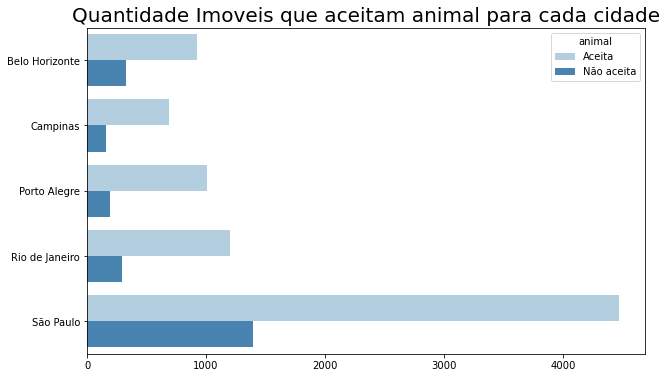

In [9]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='quantidade', y='city', hue='animal', data=quant_animal_por_cidade, orient='h', palette='Blues')
barras.set_title('Quantidade Imoveis que aceitam animal para cada cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None, xlabel=None)
plt.show()

In [10]:
media_animal = dataset.groupby('animal')['total'].mean().to_frame()
media_animal.rename(index={0: 'Aceita', 1: 'Não Aceita'}, columns={'total': 'Média dos alugueis'}, inplace=True)
media_animal

,Média dos alugueis
animal,
Aceita,5331.675910
Não Aceita,4607.752747


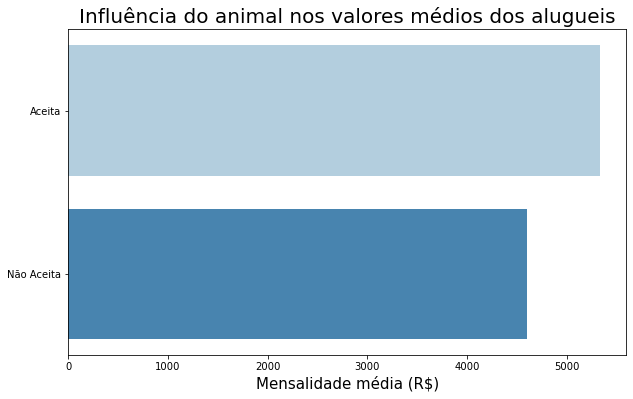

In [11]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x=media_animal['Média dos alugueis'], y=media_animal.index, data=media_animal, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do animal nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

Em uma visão macro, em média, os imóveis que não aceitam animais são mais baratos em relação aos que aceitam.

In [12]:
media_animal_por_cidade = dataset.groupby(['city', 'animal'])['total'].mean().round(2).reset_index()
media_animal_por_cidade.replace({0: 'Aceita', 1: 'Não aceita'}, inplace=True)
media_animal_por_cidade

,city,animal,total
0,Belo Horizonte,Aceita,4719.46
1,Belo Horizonte,Não aceita,3898.72
2,Campinas,Aceita,3300.27
3,Campinas,Não aceita,2631.56
4,Porto Alegre,Aceita,2987.38
5,Porto Alegre,Não aceita,2844.34
6,Rio de Janeiro,Aceita,4577.00
7,Rio de Janeiro,Não aceita,4352.07
8,São Paulo,Aceita,6502.58
9,São Paulo,Não aceita,5290.52


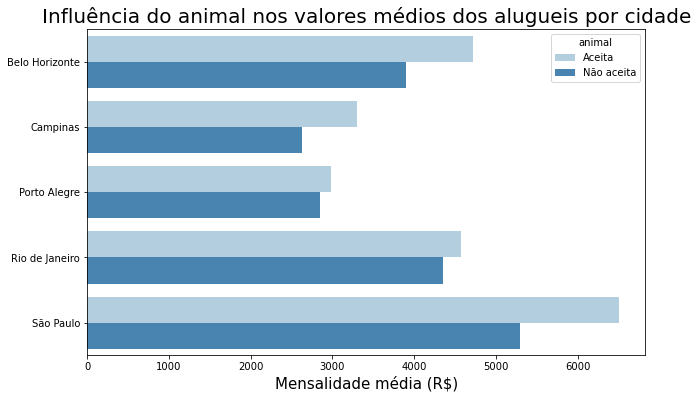

In [13]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y='city', hue='animal', data=media_animal_por_cidade, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do animal nos valores médios dos alugueis por cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

Em média, imóveis que aceitam animais são mais caros em todas as cidades. A cidade de São Paulo possui a maior discrepância do valor médio dentre as cidades.

### Inpacto dos imóveis serem monbiliados sobre o valor do aluguel

In [14]:
quant_mobiliada_por_cidade = dataset.groupby(['city', 'furniture'])['total'].count().round(2).reset_index()
quant_mobiliada_por_cidade.replace({0:'Mobiliada', 1: 'Não mobiliada'}, inplace=True)
quant_mobiliada_por_cidade.rename({'total': 'quantidade'}, axis=1, inplace=True)
quant_mobiliada_por_cidade

,city,furniture,quantidade
0,Belo Horizonte,Mobiliada,175
1,Belo Horizonte,Não mobiliada,1077
2,Campinas,Mobiliada,111
3,Campinas,Não mobiliada,740
4,Porto Alegre,Mobiliada,319
5,Porto Alegre,Não mobiliada,873
6,Rio de Janeiro,Mobiliada,405
7,Rio de Janeiro,Não mobiliada,1094
8,São Paulo,Mobiliada,1589
9,São Paulo,Não mobiliada,4277


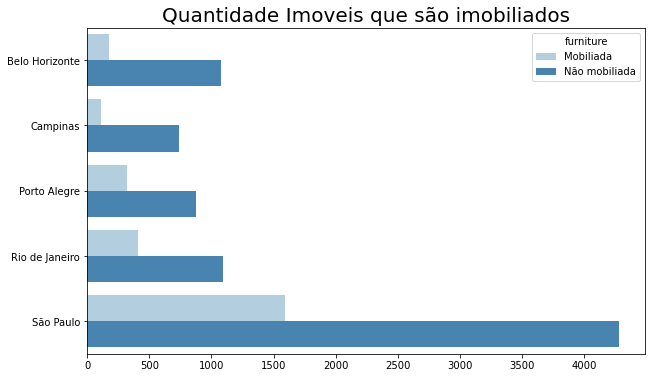

In [15]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='quantidade', y='city', hue='furniture', data=quant_mobiliada_por_cidade, orient='h', palette='Blues')
barras.set_title('Quantidade Imoveis que são imobiliados', fontdict={'fontsize': 20})
barras.set(ylabel=None, xlabel=None)
plt.show()

In [16]:
media_mobilia = dataset.groupby('furniture')['total'].mean().round(2).to_frame()
media_mobilia.rename(index={0:'Mobiliada', 1: 'Não mobiliada'}, columns={'total': 'Média dos alugueis'}, inplace=True)
media_mobilia

,Média dos alugueis
furniture,
Mobiliada,6453.97
Não mobiliada,4757.35


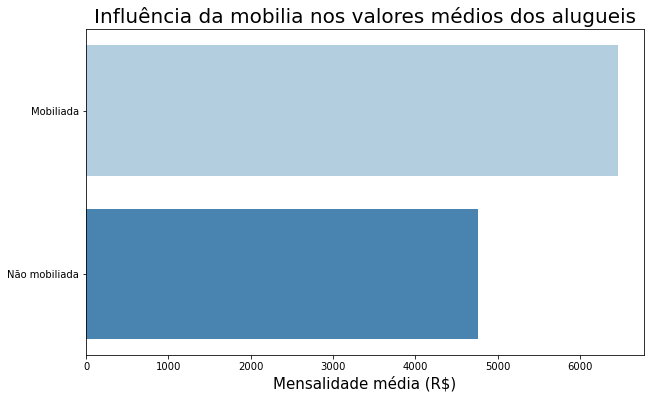

In [17]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='Média dos alugueis', y=media_mobilia.index, data=media_mobilia, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência da mobilia nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

Em uma visão macro, em média, os imóveis que são mobiliados são mais caros em relação aos que não são.

In [18]:
media_mobilia_por_cidade = dataset.groupby(['city', 'furniture'])['total'].mean().round(2).reset_index()
media_mobilia_por_cidade.replace({0:'Mobiliada', 1: 'Não mobiliada'}, inplace=True)
media_mobilia_por_cidade

,city,furniture,total
0,Belo Horizonte,Mobiliada,5876.19
1,Belo Horizonte,Não mobiliada,4283.84
2,Campinas,Mobiliada,3808.92
3,Campinas,Não mobiliada,3079.38
4,Porto Alegre,Mobiliada,3818.61
5,Porto Alegre,Não mobiliada,2652.84
6,Rio de Janeiro,Mobiliada,5788.32
7,Rio de Janeiro,Não mobiliada,4067.71
8,São Paulo,Mobiliada,7401.09
9,São Paulo,Não mobiliada,5772.87


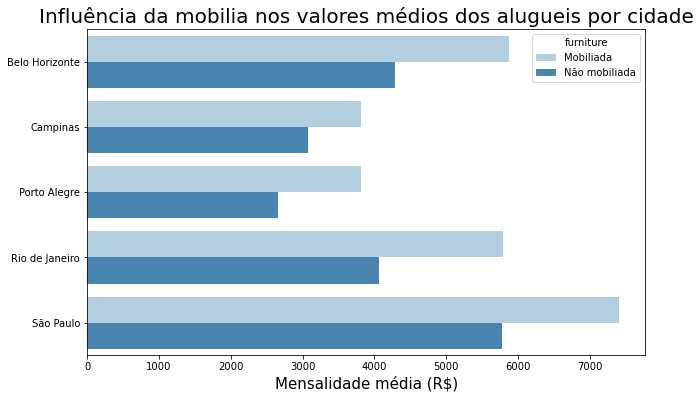

In [19]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y='city', hue='furniture', data=media_mobilia_por_cidade, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência da mobilia nos valores médios dos alugueis por cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None)

# for container in barras.containers:
#     barras.bar_label(container)

plt.show()

Em média, imóveis mobiliadosmais são mais caros em todas as cidades. A cidade de São Paulo possui a maior discrepância de valor dentre as cidades.

### Influência do andar sobre os alugueis dos imóveis dos apartamentos (a partir do 1 andar)


In [20]:
media_andar = dataset[dataset['floor'] > 0].groupby('floor')['total'].mean().to_frame()
media_andar['Quantidade'] = dataset.groupby('floor')['floor'].count()
media_andar

,total,Quantidade
floor,,
1,3922.533828,1079
2,3781.795939,985
3,4052.591398,930
4,4539.942359,746
5,5130.663333,600
6,4990.102612,536
7,5457.405242,496
8,5731.457143,490
9,5854.314363,369


Devido a pouca quantidade de informações dos andares supeiores a 22, vamos removelos da análise:

In [21]:
# Selecionando os andares que possui ocorrencia maior que 40
andares = media_andar.query('Quantidade > 40')

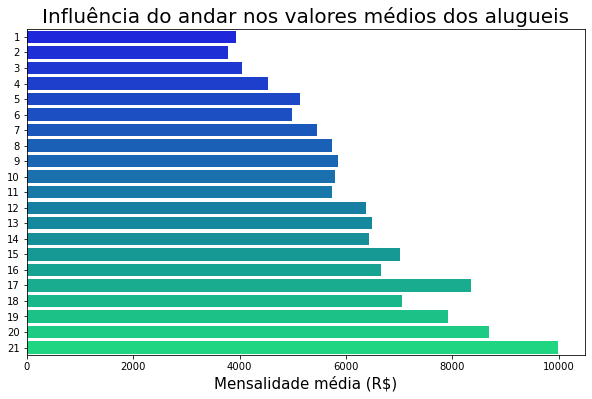

In [22]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y=andares.index, data=andares, orient='h', palette='winter')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do andar nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

O gráfico demostra uma tendencia de aumento nos valores dos alugueis com o aumento dos andares. As possíveis explicações de acordo com os especialista são a vista e quantidade de ruídos. Um apartamento no andar mais alto proporciona uma melhor vista. Uma menor quantidade de ruídos vindos da rua faz com que os andares superiores sejam os preferidos dos moradores.

### Influência da localização (cidade) sobre os custos de aluguéis

Utilizando a função cut do pandas para segmentar e classificar valores totais:

In [23]:
intervalos_total = pd.cut(dataset.total, [0, 1500, 3000, 4500, 6000, 7500, 10000, np.inf])
intervalos_total[:3]

0     (4500.0, 6000.0]
1    (7500.0, 10000.0]
2     (3000.0, 4500.0]
Name: total, dtype: category
Categories (7, interval[float64, right]): [(0.0, 1500.0] < (1500.0, 3000.0] < (3000.0, 4500.0] < (4500.0, 6000.0] < (6000.0, 7500.0] < (7500.0, 10000.0] < (10000.0, inf]]

Criando um novo dataframe com as infomações dos intervalos:

In [24]:
df_intervalos = pd.DataFrame({'intervalo_total': intervalos_total,
                                'area': dataset['area'],
                                'quartos': dataset['rooms'],
                                'condominio': dataset['hoa'],
                                'IPTU': dataset['property tax'],
                                'aluguel': dataset['rent amount'],
                                'seguro_incendio': dataset['fire insurance'],
                                'cidades': dataset['city']
                                })

In [25]:
medias_areas_por_cidade = df_intervalos.pivot_table(values='area',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)    # função que irá ser execultada para agrupar os valores
medias_areas_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",58.15,55.79,49.65,41.08,47.32
"(1500.0, 3000.0]",95.83,83.53,74.34,62.82,66.34
"(3000.0, 4500.0]",158.83,142.98,133.70,94.23,100.62
"(4500.0, 6000.0]",231.87,195.49,189.79,117.29,137.74
"(6000.0, 7500.0]",283.08,257.71,243.70,140.47,174.41
"(7500.0, 10000.0]",340.05,342.82,316.52,185.24,224.81
"(10000.0, inf]",370.02,422.05,353.32,273.11,313.44


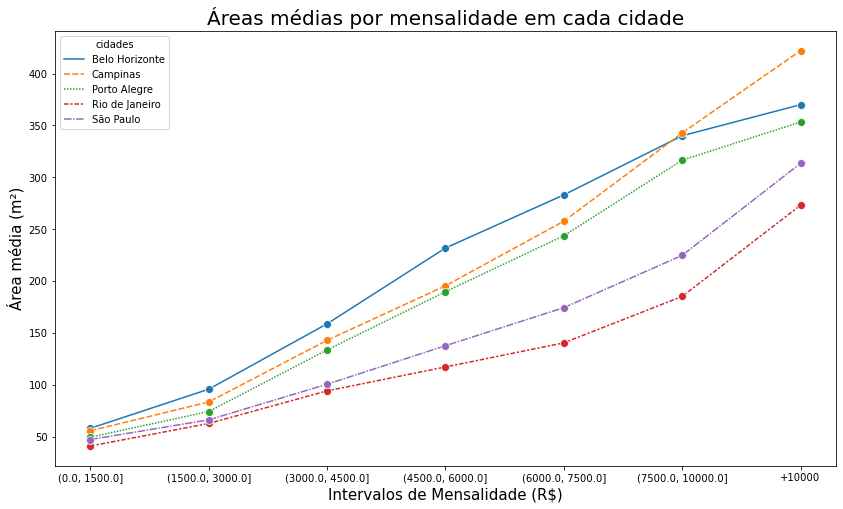

In [26]:
medias_areas_por_cidade = medias_areas_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_areas_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Área média (m²)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_areas_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Áreas médias por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

O aumento da área implica no aumento do custo total de aluguel, o que confirma correlação positiva entre as features. O Rio de Janeiro é a cidade que possui a menor média de área para todas as classes de mensalidade, enquanto Belo Horizonte possui a maior média de área para as classes até R$10000,00. Então, provando que a há influência cidade (localização) sobre o custo total de aluguel dos imoveis.

In [27]:
medias_IPTU_por_cidade = df_intervalos.pivot_table(values='IPTU',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)   # função que irá ser execultada para agrupar os valores
medias_IPTU_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",42.65,32.81,32.50,28.12,30.16
"(1500.0, 3000.0]",109.88,82.96,73.44,71.56,62.94
"(3000.0, 4500.0]",225.97,182.22,142.12,173.50,150.81
"(4500.0, 6000.0]",308.33,294.72,336.62,268.34,294.01
"(6000.0, 7500.0]",423.97,363.29,369.00,334.42,439.56
"(7500.0, 10000.0]",538.70,425.09,494.85,567.34,681.14
"(10000.0, inf]",821.47,705.03,603.37,873.87,1236.78


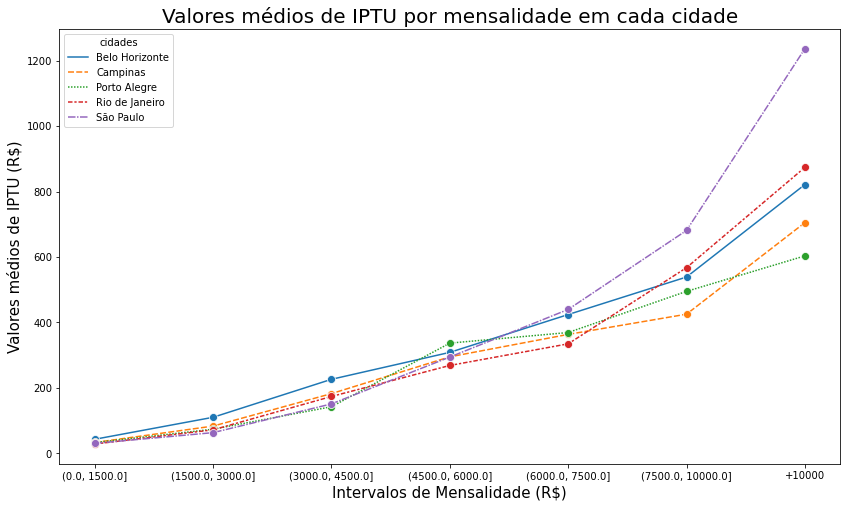

In [28]:
medias_IPTU_por_cidade = medias_IPTU_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_IPTU_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Valores médios de IPTU (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_IPTU_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Valores médios de IPTU por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

Os valores médios de IPTU se mantem relativamente parecidos no intervalo de 0 até 7500,00 reais. Para valores médios de alugueis maiores de R$7500,00, na cidade de São Paulo há um grande aumento nos valores de IPTU, se distânciando bastante das outras cidades.

### Composição do preço dos alugueis para a cidade de São Paulo por intervalo de área

Escolhendo a cidade de São Paulo para analise, já que a cidade com maior número de informções. Separando novamente as infomações em um dataset por intervalos de alugueis e agrupando as informações através das médias dos dados de cada intervalo.

In [29]:
intervalos_area = pd.cut(dataset.area, [0, 50, 75, 100, 125, 150, 200, np.inf])

df_intervalos_area = pd.DataFrame({'intervalo_area': intervalos_area,
                                'condominio': dataset['hoa'],
                                'IPTU': dataset['property tax'],
                                'aluguel': dataset['rent amount'],
                                'seguro_incendio': dataset['fire insurance'],
                                'cidades': dataset['city']
                                })

df_cidade_SP = df_intervalos.query('cidades == "São Paulo"')


composicao_area_SP = df_intervalos_area.pivot_table(values=['condominio', 'IPTU', 'aluguel', 'seguro_incendio'],
                                    index='intervalo_area',
                                    aggfunc='mean').round(2).reset_index()

composicao_area_SP

,intervalo_area,IPTU,aluguel,condominio,seguro_incendio
0,"(0.0, 50.0]",54.77,1722.18,417.58,22.77
1,"(50.0, 75.0]",84.46,1972.30,548.76,26.15
2,"(75.0, 100.0]",156.47,2792.50,734.43,37.26
3,"(100.0, 125.0]",225.45,3480.42,910.19,46.69
4,"(125.0, 150.0]",317.68,4326.58,1099.20,57.62
5,"(150.0, 200.0]",446.90,5472.81,1323.73,73.98
6,"(200.0, inf]",913.68,7834.83,1617.82,110.55


Plotando o gráfico da composição dos valores médios de custo por mensalidade para a cidade de São Paulo

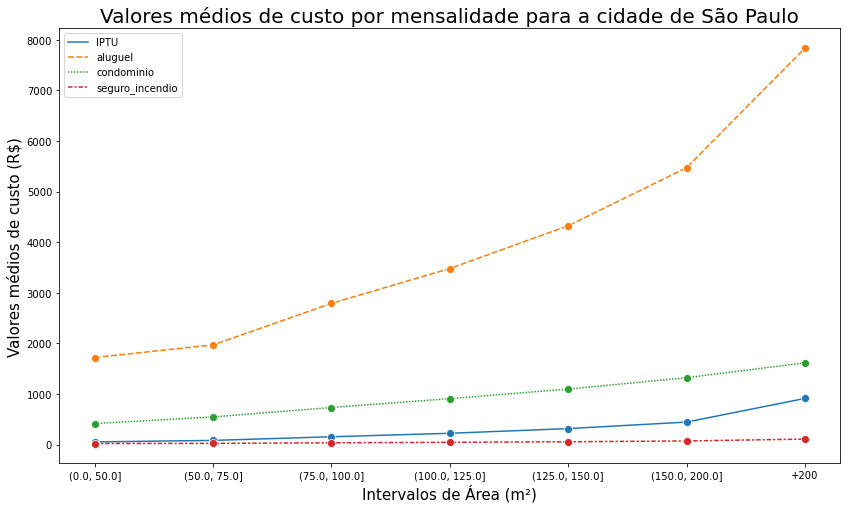

In [30]:
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=composicao_area_SP, marker='o', markersize=8)
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Área (m²)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(composicao_area_SP['intervalo_area'][:-1]) + ['+200'])
x1.set_title('Valores médios de custo por mensalidade para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()

É possivel perceber através do gráfico anterior que o preço médio do aluguel é a feature que sobre maior influência com o aumento da área do imóvel.

<Figure size 1080x720 with 0 Axes>

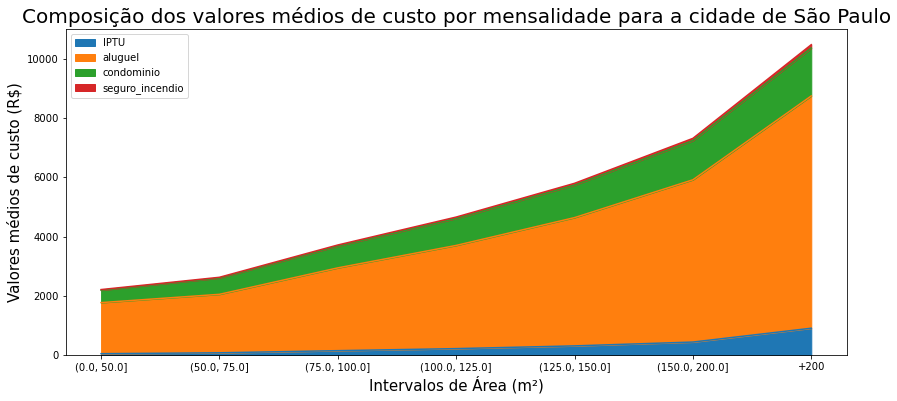

In [31]:
plt.figure(figsize=(15, 10))
x1 = composicao_area_SP.iloc[:,1:].plot.area()
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Área (m²)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(composicao_area_SP['intervalo_area'][:-1]) + ['+200'])
x1.set_title('Composição dos valores médios de custo por mensalidade para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()

Através do gráfico da composição é possível ver que a o valor do aluguel boa parte do preço médio total do aluguel, seguido pelo valor do condomínio.

In [32]:
composicao_porcentageme = composicao_area_SP[:]
composicao_porcentageme['aluguel_porc'] = composicao_porcentageme['aluguel'] / (composicao_porcentageme['IPTU'] + composicao_porcentageme['aluguel'] + composicao_porcentageme['condominio']+ composicao_porcentageme['seguro_incendio'])
composicao_porcentageme['condominio_porc'] = composicao_porcentageme['condominio'] / (composicao_porcentageme['IPTU'] + composicao_porcentageme['aluguel'] + composicao_porcentageme['condominio']+ composicao_porcentageme['seguro_incendio'])
composicao_porcentageme['IPTU_porc'] = composicao_porcentageme['IPTU'] / (composicao_porcentageme['IPTU'] + composicao_porcentageme['aluguel'] + composicao_porcentageme['condominio']+ composicao_porcentageme['seguro_incendio'])
composicao_porcentageme['seguro_incendio_porc'] = composicao_porcentageme['seguro_incendio'] / (composicao_porcentageme['IPTU'] + composicao_porcentageme['aluguel'] + composicao_porcentageme['condominio']+ composicao_porcentageme['seguro_incendio'])
composicao_porcentageme

,intervalo_area,IPTU,aluguel,condominio,seguro_incendio,aluguel_porc,condominio_porc,IPTU_porc,seguro_incendio_porc
0,"(0.0, 50.0]",54.77,1722.18,417.58,22.77,0.776701,0.188328,0.024701,0.010269
1,"(50.0, 75.0]",84.46,1972.30,548.76,26.15,0.749448,0.208522,0.032094,0.009937
2,"(75.0, 100.0]",156.47,2792.50,734.43,37.26,0.750539,0.197392,0.042054,0.010014
3,"(100.0, 125.0]",225.45,3480.42,910.19,46.69,0.746431,0.195205,0.048351,0.010013
4,"(125.0, 150.0]",317.68,4326.58,1099.20,57.62,0.745823,0.189482,0.054762,0.009933
5,"(150.0, 200.0]",446.90,5472.81,1323.73,73.98,0.747915,0.180901,0.061073,0.010110
6,"(200.0, inf]",913.68,7834.83,1617.82,110.55,0.747821,0.154418,0.087209,0.010552


Investigando mais a fundo a composição do custo total de aluguel, percebemos que o valor médio do aluguel representa por volta de 75% do custo total, enquanto o valor do condomínio cerca de 18%. É possíveel também enxergar que as proporções se mantêm mesmo com o aumento da área para todas as features analisadas. Então negamos a hípoteses que há variação de composição do custo total de aluguel quando a aumento da área.